# Speech Emotion Recognition


#### Task Description：
Fine-tune Hubert model on the RAVDESS dataset for Speech Emotion Recognition.


#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

## 1. General Preparation

Import some common libraries.

In [ ]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.9 MB/s 
     |████████████████████████████████| 163 kB 69.0 MB/s 
     |████████████████████████████████| 7.6 MB 46.5 MB/s 


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 39.9 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 67.3 MB/s 
     |████████████████████████████████| 212 kB 63.3 MB/s 
     |████████████████████████████████| 127 kB 67.3 MB/s 
     |████████████████████████████████| 115 kB 62.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [ ]:
import time
from tqdm import tqdm

Use GPU Facilities.

In [ ]:
import torch
cuda_id = 0
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:0 - Tesla T4


## 2. Data Processing

### 2.1 Load RAVDESS dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

#RAV = "/content/drive/MyDrive/Machine_Learning/Audio_Speech_Actors_01-24/"
RAV = '/content/drive/MyDrive/ser-ravdess/'
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
#RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

sad         192
disgust     192
angry       192
fear        192
calm        192
happy       192
surprise    192
neutral      96
Name: emotion, dtype: int64

In [ ]:
RAV_df

,gender,emotion,labels,path
0,male,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_01/03...
1,male,disgust,7,/content/drive/MyDrive/ser-ravdess/Actor_01/03...
2,male,angry,5,/content/drive/MyDrive/ser-ravdess/Actor_01/03...
3,male,fear,6,/content/drive/MyDrive/ser-ravdess/Actor_01/03...
4,male,calm,2,/content/drive/MyDrive/ser-ravdess/Actor_01/03...
...,...,...,...,...
1435,female,surprise,8,/content/drive/MyDrive/ser-ravdess/Actor_24/03...
1436,female,fear,6,/content/drive/MyDrive/ser-ravdess/Actor_24/03...
1437,female,disgust,7,/content/drive/MyDrive/ser-ravdess/Actor_24/03...
1438,female,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_24/03...


In [ ]:
CustomDataset = "/content/drive/MyDrive/Custom_DataSet/";
dir_list = os.listdir(CustomDataset)

emotion = []
path = []
for f in dir_list:
    part = f.split('.')[0].split('-')
    emotion.append(int(part[1]))
    path.append(CustomDataset + f)

CustomeDataset_df = pd.DataFrame(emotion)
CustomeDataset_df = CustomeDataset_df.replace({3:'happy', 4:'sad', 5:'angry'})
CustomeDataset_df = pd.concat([CustomeDataset_df, pd.DataFrame(emotion)],axis=1)
CustomeDataset_df.columns = ['emotion','labels']
CustomeDataset_df = pd.concat([CustomeDataset_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CustomeDataset_df.emotion.value_counts()

happy    20
angry    19
sad      12
Name: emotion, dtype: int64

In [ ]:
CustomeDataset_df.head()

,emotion,labels,path
0,sad,4,/content/drive/MyDrive/Custom_DataSet/03-04.wav
1,angry,5,/content/drive/MyDrive/Custom_DataSet/05-05.wav
2,sad,4,/content/drive/MyDrive/Custom_DataSet/05-04.wav
3,happy,3,/content/drive/MyDrive/Custom_DataSet/04-03.wav
4,angry,5,/content/drive/MyDrive/Custom_DataSet/03-05.wav


In this demonstration, we only choose 4 emotions, neutral, happy, sad and angry.

In [ ]:
RAV_df = RAV_df[(RAV_df["emotion"]=="happy") | (RAV_df["emotion"]=="sad") | (RAV_df["emotion"]=="angry")]

Split into training data and test data.

In [ ]:
# RAV_df = RAV_df.sample(frac=0.1)
train_df = RAV_df.sample(frac=0.8)
test_df = RAV_df.drop(train_df.index)

Let's have a look at the training data.

In [ ]:
train_df

,gender,emotion,labels,path
512,male,angry,5,/content/drive/MyDrive/ser-ravdess/Actor_09/03...
83,female,happy,3,/content/drive/MyDrive/ser-ravdess/Actor_02/03...
44,male,happy,3,/content/drive/MyDrive/ser-ravdess/Actor_01/03...
1366,male,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_23/03...
1006,male,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_17/03...
...,...,...,...,...
724,male,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_13/03...
1142,female,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_20/03...
658,male,angry,5,/content/drive/MyDrive/ser-ravdess/Actor_11/03...
922,female,happy,3,/content/drive/MyDrive/ser-ravdess/Actor_16/03...


In [ ]:
train_df["emotion"].value_counts()

angry    155
sad      155
happy    151
Name: emotion, dtype: int64

In [ ]:
test_df["emotion"].value_counts()

happy    41
angry    37
sad      37
Name: emotion, dtype: int64

In [ ]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                  male
emotion                                                angry
labels                                                     5
path       /content/drive/MyDrive/ser-ravdess/Actor_09/03...
Name: 512, dtype: object


In [ ]:
# Display the first data of the custom dataset.
id = 0
print(CustomeDataset_df.iloc[id])
ipd.Audio(data=CustomeDataset_df.iloc[id]["path"], autoplay=True, rate=16000)

emotion                                                sad
labels                                                   4
path       /content/drive/MyDrive/Custom_DataSet/03-04.wav
Name: 0, dtype: object


### 2.2 Tokenization

In [ ]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example                               #how is Dataset used. 

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)
custom_data = Dataset.from_pandas(CustomeDataset_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
custom_encodings = feature_extractor(list(custom_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

  0%|          | 0/461 [00:00<?, ?ex/s]

  0%|          | 0/115 [00:00<?, ?ex/s]

  0%|          | 0/51 [00:00<?, ?ex/s]

Downloading:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
train_data

Dataset({
    features: ['gender', 'emotion', 'labels', 'path', '__index_level_0__', 'speech'],
    num_rows: 461
})

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [ ]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {1:0, 2:0, 3:1, 4:3, 5:2}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))
custom_dataset = EmotionDataset(custom_encodings, list(custom_data["labels"]))

## 3. Loading the Model and Optimizer 

In [ ]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

## 4. Training

Prepare some utility functions.

In [ ]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [ ]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 10  # Note By Rachit, make this value  3 or more maybe, set your runtime type to GPU

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/10


100%|██████████| 231/231 [02:01<00:00,  1.91it/s, Loss=0.191, Accuracy=0.692]


Epoch 2/10


100%|██████████| 231/231 [01:57<00:00,  1.96it/s, Loss=2.131, Accuracy=0.785]


Epoch 3/10


100%|██████████| 231/231 [01:58<00:00,  1.94it/s, Loss=1.339, Accuracy=0.818]


Epoch 4/10


100%|██████████| 231/231 [01:58<00:00,  1.95it/s, Loss=0.979, Accuracy=0.820]


Epoch 5/10


100%|██████████| 231/231 [01:58<00:00,  1.95it/s, Loss=0.215, Accuracy=0.863]


Epoch 6/10


100%|██████████| 231/231 [01:58<00:00,  1.96it/s, Loss=0.137, Accuracy=0.909]


Epoch 7/10


100%|██████████| 231/231 [01:58<00:00,  1.95it/s, Loss=0.002, Accuracy=0.915]


Epoch 8/10


100%|██████████| 231/231 [01:58<00:00,  1.95it/s, Loss=0.014, Accuracy=0.941]


Epoch 9/10


100%|██████████| 231/231 [01:58<00:00,  1.94it/s, Loss=0.528, Accuracy=0.939]


Epoch 10/10


100%|██████████| 231/231 [01:58<00:00,  1.95it/s, Loss=0.004, Accuracy=0.926]


Visualise the training loss and accuracy.

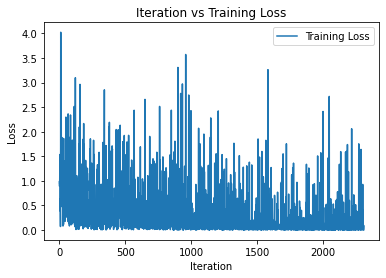

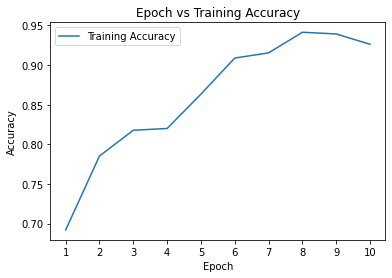

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [ ]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 115/115 [00:08<00:00, 13.46it/s, loss=0.000, accuracy=0.948]


The final accuracy on the test dataset: 94.7826%


Check the result.

In [ ]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:4], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]

,index,gender,emotion,labels,path,Model Prediction
0,12,male,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,ang
2,37,male,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,hap
4,53,male,happ,3,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,hap
5,92,female,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_02/03...,ang
7,122,male,happ,3,/content/drive/MyDrive/ser-ravdess/Actor_03/03...,hap
...,...,...,...,...,...,...
107,1381,female,happ,3,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,hap
109,1387,female,happ,3,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,hap
110,1405,female,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,ang
112,1415,female,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,ang


Display the Confusion Matrix of the result.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(df_record["Ground Truth"],df_record["Model Prediction"]))

              precision    recall  f1-score   support

         ang       0.97      0.92      0.94        37
         hap       0.93      0.93      0.93        41
         sad       0.95      1.00      0.97        37

    accuracy                           0.95       115
   macro avg       0.95      0.95      0.95       115
weighted avg       0.95      0.95      0.95       115



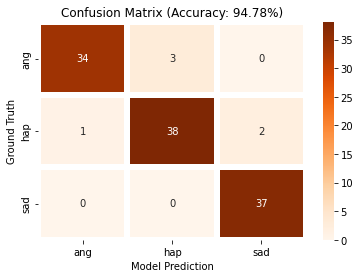

In [ ]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [ ]:
# Testing our custom dataset

# Get test data by DataLoader
custom_loader = DataLoader(custom_dataset, batch_size=1)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(custom_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 51/51 [00:07<00:00,  6.58it/s, loss=0.024, accuracy=0.431]


The final accuracy on the test dataset: 43.1373%


In [ ]:
# Convert custom record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:4], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]

,index,gender,emotion,labels,path,Model Prediction
0,12,male,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,sad
1,17,male,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,hap
2,37,male,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,hap
3,50,male,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,hap
4,53,male,happ,3,/content/drive/MyDrive/ser-ravdess/Actor_01/03...,hap
...,...,...,...,...,...,...
110,1405,female,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,NaN
111,1406,female,sad,4,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,NaN
112,1415,female,angr,5,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,NaN
113,1423,female,happ,3,/content/drive/MyDrive/ser-ravdess/Actor_24/03...,NaN


In [ ]:
print(classification_report(df_record["Ground Truth"],df_record["Model Prediction"]))

              precision    recall  f1-score   support

         ang       0.25      0.16      0.19        19
         hap       0.36      0.50      0.42        20
         sad       0.82      0.75      0.78        12

    accuracy                           0.43        51
   macro avg       0.48      0.47      0.46        51
weighted avg       0.43      0.43      0.42        51



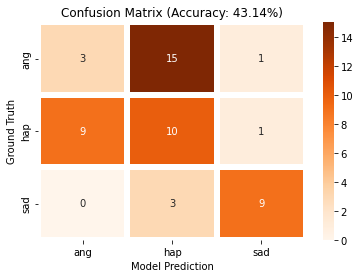

In [ ]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
